## Pakete

In [1]:
%pip install scikit-learn
%pip install matplotlib
%pip install seaborn


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

## Allgemeine Information zum Datensatz

In [3]:
# df holen
#import pandas as pd
#davor muss mittels `os` die directory über dem `src` für die Daten und Ergebnisse angeheftet werden
import os
os.getcwd()
os.chdir(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))


aids = pd.read_csv('data/aids.csv', sep =",")

In [4]:
aids.head(10)

,num,time,trt,age,wtkg,hemo,homo,drugs,karnof,oprior,...,str2,strat,symptom,treat,offtrt,cd40,cd420,cd80,cd820,cid
0,0,948,2,48,89.8128,0,0,0,100,0,...,0,1,0,1,0,422,477,566,324,0
1,1,1002,3,61,49.4424,0,0,0,90,0,...,1,3,0,1,0,162,218,392,564,1
2,2,961,3,45,88.4520,0,1,1,90,0,...,1,3,0,1,1,326,274,2063,1893,0
3,3,1166,3,47,85.2768,0,1,0,100,0,...,1,3,0,1,0,287,394,1590,966,0
4,4,1090,0,43,66.6792,0,1,0,100,0,...,1,3,0,0,0,504,353,870,782,0
5,5,1181,1,46,88.9056,0,1,1,100,0,...,1,3,0,1,0,235,339,860,1060,0
6,6,794,0,31,73.0296,0,1,0,100,0,...,1,3,0,0,0,244,225,708,699,1
7,7,957,0,41,66.2256,0,1,1,100,0,...,1,3,0,0,0,401,366,889,720,0
8,8,198,3,40,82.5552,0,1,0,90,0,...,1,3,1,1,1,214,107,652,131,1
9,9,188,0,35,78.0192,0,1,0,100,0,...,1,3,0,0,1,221,132,221,759,1


In [5]:
aids.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2139 entries, 0 to 2138
Data columns (total 25 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   num      2139 non-null   int64  
 1   time     2139 non-null   int64  
 2   trt      2139 non-null   int64  
 3   age      2139 non-null   int64  
 4   wtkg     2139 non-null   float64
 5   hemo     2139 non-null   int64  
 6   homo     2139 non-null   int64  
 7   drugs    2139 non-null   int64  
 8   karnof   2139 non-null   int64  
 9   oprior   2139 non-null   int64  
 10  z30      2139 non-null   int64  
 11  zprior   2139 non-null   int64  
 12  preanti  2139 non-null   int64  
 13  race     2139 non-null   int64  
 14  gender   2139 non-null   int64  
 15  str2     2139 non-null   int64  
 16  strat    2139 non-null   int64  
 17  symptom  2139 non-null   int64  
 18  treat    2139 non-null   int64  
 19  offtrt   2139 non-null   int64  
 20  cd40     2139 non-null   int64  
 21  cd420    2139 

### Dictionary für das Labeling erstellen

Die Beschreibung einzelner Features befindet sich im `README`. Es werden Labels für kategoriale Features erstellt. Die Information in den Features liegt numerisch vor. Es muss kein Replacement in den Daten erfolgen.

In [6]:
trt_dict = {0: 'ZDV-only', 1: 'ZDV+ddI', 2: 'ZDV+Zal', 3: 'ddI-only'}
hemo_dict = {0: 'no-hemophilia', 1: 'hemophilia'}
homo_dict = {0: 'no-homosexual', 1: 'homosexual'}
drugs_dict = {0: 'no-IV-drugs', 1: 'IV-drugs'}
oprior_dict = {0: 'no-prior-ARVT(no-ZDV)', 1: 'prior-ARVT(no-ZDV)'}
z30_dict = {0: 'no-ZDV-Ther-30d-befor-random', 1: 'ZDV-Ther-30d-befor-random'}
zprior_dict = {0: 'no ZDV-Therapy befor randomisation', 1: 'ZDV-Therapy befor randomisation'}
race_dict = {0: 'White', 1: 'Non-White'}
gender_dict = {0: 'Female', 1: 'Male'}
str2_dict = {0: 'naive', 1: 'experienced'}
strat_dict = {1: 'Antiretroviral-Naive', 2: '>1-but<= 52-weeks-of-prior-ARVT', 3: '>52-weeks-of-prior-ARVT'}
symptom_dict = {0: 'asymptomatic', 1: 'symtomatic'}
treat_dict = {0: 'ZDV only', 1: 'others'}
offtrt_dict = {0: "no off trt befor 96 weeks",1: "off trt befor 96 weeks"}
cid_dict = {0: 'censoring', 1: 'failure'}


Da die Daten allesamt numerisch vorliegen, wird der `Dtype` *int64* anhand der formalen Kriterien automatisch auch an die kategorialen Features vergeben. D.h. die kategorialen Features wie *gender*, *treatment* oder *homosexuality* können nicht von den diskreten Features wie *age* unterschieden werden. Zum Zweck der Typisierung werden die kategorialen Features mithilfe von dem zuvor erstellten `dictionary` in den entsprechenden Datentyp konvertiert.

In [7]:
# eine Liste aller dictionary
dict1=[trt_dict,hemo_dict,homo_dict,drugs_dict, oprior_dict,z30_dict,zprior_dict,race_dict,gender_dict,str2_dict,strat_dict,symptom_dict,treat_dict,offtrt_dict,cid_dict]
len(dict1)

15

In [8]:
# eine Liste aller kategorialen Features
stri=["trt","hemo","homo","drugs","oprior","z30","zprior","race","gender","str2","strat","symptom","treat","offtrt", "cid"]
len(stri)

15

In [9]:
# Austausch numerischer Werte auf Labels
aids[stri[0]]=aids[stri[0]].replace(dict1[0])

aids[stri[1]]=aids[stri[1]].replace(dict1[1])

aids[stri[2]]=aids[stri[2]].replace(dict1[2])

aids[stri[3]]=aids[stri[3]].replace(dict1[3])

aids[stri[4]]=aids[stri[4]].replace(dict1[4])

aids[stri[5]]=aids[stri[5]].replace(dict1[5])

aids[stri[6]]=aids[stri[6]].replace(dict1[6])

aids[stri[7]]=aids[stri[7]].replace(dict1[7])

aids[stri[8]]=aids[stri[8]].replace(dict1[8])

aids[stri[9]]=aids[stri[9]].replace(dict1[9])

aids[stri[10]]=aids[stri[10]].replace(dict1[10])

aids[stri[11]]=aids[stri[11]].replace(dict1[11])

aids[stri[12]]=aids[stri[12]].replace(dict1[12])

aids[stri[13]]=aids[stri[13]].replace(dict1[13])

aids[stri[14]]=aids[stri[14]].replace(dict1[14])

## Einfache Häufigkeiten kategorialer Features

In [10]:
aids.value_counts([stri[0]])

trt     
ddI-only    561
ZDV-only    532
ZDV+Zal     524
ZDV+ddI     522
Name: count, dtype: int64

In [11]:
aids.value_counts([stri[1]])

hemo         
no-hemophilia    1959
hemophilia        180
Name: count, dtype: int64

In [12]:
aids.value_counts([stri[2]])

homo         
homosexual       1414
no-homosexual     725
Name: count, dtype: int64

In [13]:
aids.value_counts([stri[3]])

drugs      
no-IV-drugs    1858
IV-drugs        281
Name: count, dtype: int64

In [14]:
aids.value_counts([stri[4]])

oprior               
no-prior-ARVT(no-ZDV)    2092
prior-ARVT(no-ZDV)         47
Name: count, dtype: int64

In [15]:
aids.value_counts([stri[5]])

z30                         
ZDV-Ther-30d-befor-random       1177
no-ZDV-Ther-30d-befor-random     962
Name: count, dtype: int64

In [16]:
aids.value_counts([stri[6]])

zprior                         
ZDV-Therapy befor randomisation    2139
Name: count, dtype: int64

Es scheinen **alle** irgendwann eine ZDV-Therapie davor gehabt zu haben. Daher ist das `z30` Feature mehr informativ.

In [17]:
aids.value_counts([stri[7]])

race     
White        1522
Non-White     617
Name: count, dtype: int64

In [18]:
aids.value_counts([stri[8]])

gender
Male      1771
Female     368
Name: count, dtype: int64

In [19]:
aids.value_counts([stri[9]])

str2       
experienced    1253
naive           886
Name: count, dtype: int64

In [20]:
aids.value_counts([stri[10]])

strat                          
Antiretroviral-Naive               886
>52-weeks-of-prior-ARVT            843
>1-but<= 52-weeks-of-prior-ARVT    410
Name: count, dtype: int64

Es zeigt sich eine gewisse Diskrepanz zwischen `oprior` und `strat`. In beiden geht es um vorige antiretrovirale Therapie. Jedoch weist `oprior` viel wenieger n mit *keine ARVT* als `strat` mit *ARVT-naive*. In der [Publikation](https://www.nejm.org/doi/full/10.1056/NEJM199610103351501) lässt sich das nicht schlüssig nachvollziehen. Aufgrund von besserer Verteilung wird `strat` in die Modellierung aufgenommen. 

In [21]:
aids.value_counts([stri[11]])

symptom     
asymptomatic    1769
symtomatic       370
Name: count, dtype: int64

In [22]:
aids.value_counts([stri[12]])

treat   
others      1607
ZDV only     532
Name: count, dtype: int64

In [23]:
aids.value_counts([stri[13]])

offtrt                   
no off trt befor 96 weeks    1363
off trt befor 96 weeks        776
Name: count, dtype: int64

In [24]:
aids.value_counts([stri[14]])

cid      
censoring    1618
failure       521
Name: count, dtype: int64

In [25]:
# einen temporären Datensatz mit stetigen Features erstellen
aidsnum = aids.drop(stri,axis=1)
aidsnum.shape

aidsnum.columns

Index(['num', 'time', 'age', 'wtkg', 'karnof', 'preanti', 'cd40', 'cd420',
       'cd80', 'cd820'],
      dtype='object')

In [26]:
# für weitere Tables ID-Nummerierung enfernen
aidsnum = aidsnum.drop(["num"],axis=1)

In [27]:
aidsnum.info() #check

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2139 entries, 0 to 2138
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   time     2139 non-null   int64  
 1   age      2139 non-null   int64  
 2   wtkg     2139 non-null   float64
 3   karnof   2139 non-null   int64  
 4   preanti  2139 non-null   int64  
 5   cd40     2139 non-null   int64  
 6   cd420    2139 non-null   int64  
 7   cd80     2139 non-null   int64  
 8   cd820    2139 non-null   int64  
dtypes: float64(1), int64(8)
memory usage: 150.5 KB


## Explorative Analyse stetiger Features

In [28]:
aidsnum.describe(include="all")

,time,age,wtkg,karnof,preanti,cd40,cd420,cd80,cd820
count,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000
mean,879.098177,35.248247,75.125311,95.446470,379.175783,350.501169,371.307153,986.627396,935.369799
std,292.274324,8.709026,13.263164,5.900985,468.657526,118.573863,144.634909,480.197750,444.976051
min,14.000000,12.000000,31.000000,70.000000,0.000000,0.000000,49.000000,40.000000,124.000000
25%,727.000000,29.000000,66.679200,90.000000,0.000000,263.500000,269.000000,654.000000,631.500000
50%,997.000000,34.000000,74.390400,100.000000,142.000000,340.000000,353.000000,893.000000,865.000000
75%,1091.000000,40.000000,82.555200,100.000000,739.500000,423.000000,460.000000,1207.000000,1146.500000
max,1231.000000,70.000000,159.939360,100.000000,2851.000000,1199.000000,1119.000000,5011.000000,6035.000000


### Verteilung der stetigen Parameter

#### Gewicht

Text(0.5, 0, 'Gewicht in Kilogramm')

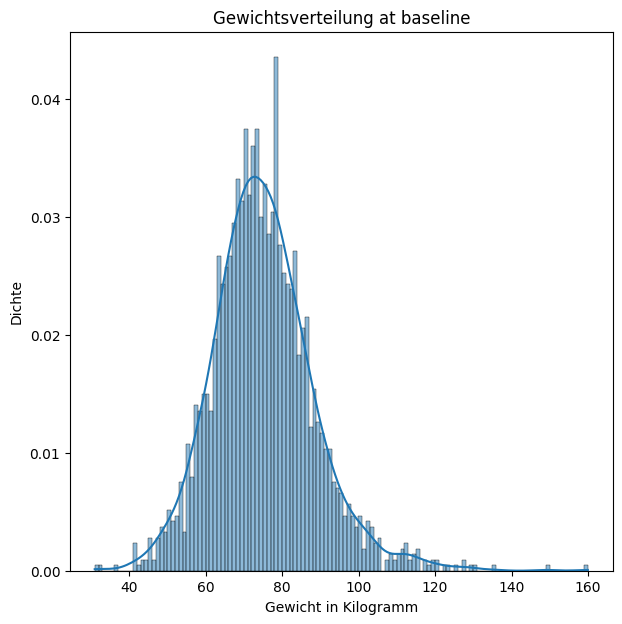

In [29]:
plt.figure(figsize=(7,7))
plot1 = sns.histplot(aids['wtkg'], binwidth=1, kde=True, stat="density") #stat["frequency", "density", "probability"]
plot1.set_title("Gewichtsverteilung at baseline", fontsize=12) # Beschriftungen aus pyplot
plot1.set_ylabel("Dichte", fontsize=10)
plot1.set_xlabel("Gewicht in Kilogramm", fontsize=10)

#### Alter

Text(0.5, 0, 'Alter in Jahren')

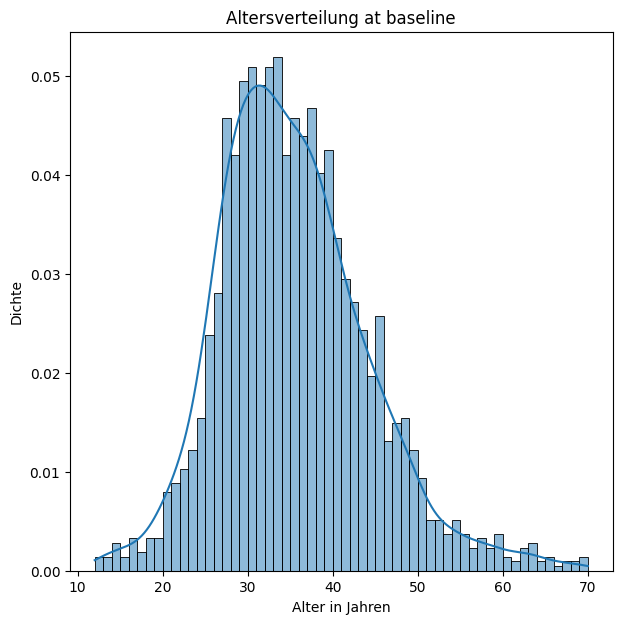

In [30]:
plt.figure(figsize=(7,7))
plot1 = sns.histplot(aids['age'], binwidth=1, kde=True, stat="density") #stat["frequency", "density", "probability"]
plot1.set_title("Altersverteilung at baseline", fontsize=12) # Beschriftungen aus pyplot
plot1.set_ylabel("Dichte", fontsize=10)
plot1.set_xlabel("Alter in Jahren", fontsize=10)

#### CD-4 Marker at baseline und nach 20 Wochen

Text(0.5, 0, 'CD-4 T-cells Marker')

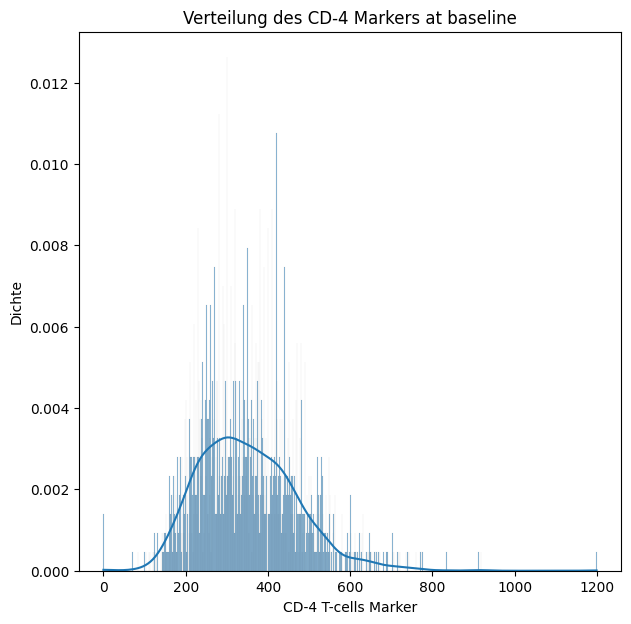

In [31]:
#at baseline

plt.figure(figsize=(7,7))
plot1 = sns.histplot(aids['cd40'], binwidth=1, kde=True, stat="density") #stat["frequency", "density", "probability"]
plot1.set_title("Verteilung des CD-4 Markers at baseline", fontsize=12) # Beschriftungen aus pyplot
plot1.set_ylabel("Dichte", fontsize=10)
plot1.set_xlabel("CD-4 T-cells Marker", fontsize=10)

Text(0.5, 0, 'CD-4 T-cells Marker')

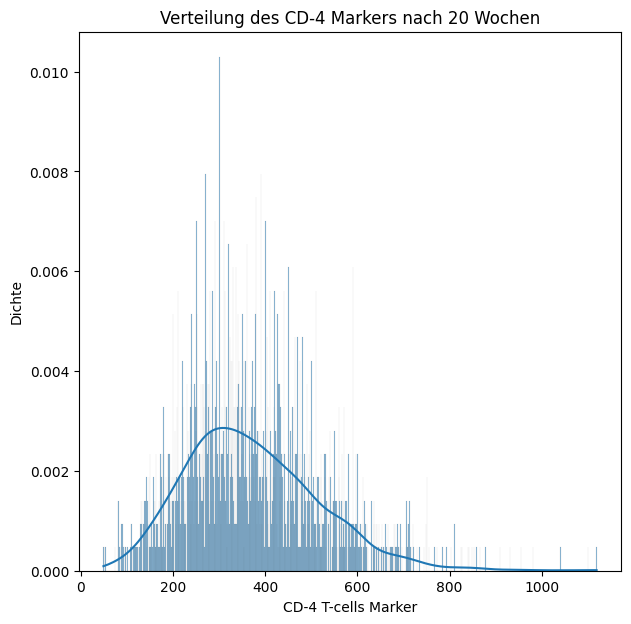

In [32]:
# nach 20 Wochen

plt.figure(figsize=(7,7))
plot1 = sns.histplot(aids['cd420'], binwidth=1, kde=True, stat="density") #stat["frequency", "density", "probability"]
plot1.set_title("Verteilung des CD-4 Markers nach 20 Wochen", fontsize=12) # Beschriftungen aus pyplot
plot1.set_ylabel("Dichte", fontsize=10)
plot1.set_xlabel("CD-4 T-cells Marker", fontsize=10)

#### CD-8 Marker at baseline und nach 20 Wochen

Text(0.5, 0, 'CD-8 T-cells Marker')

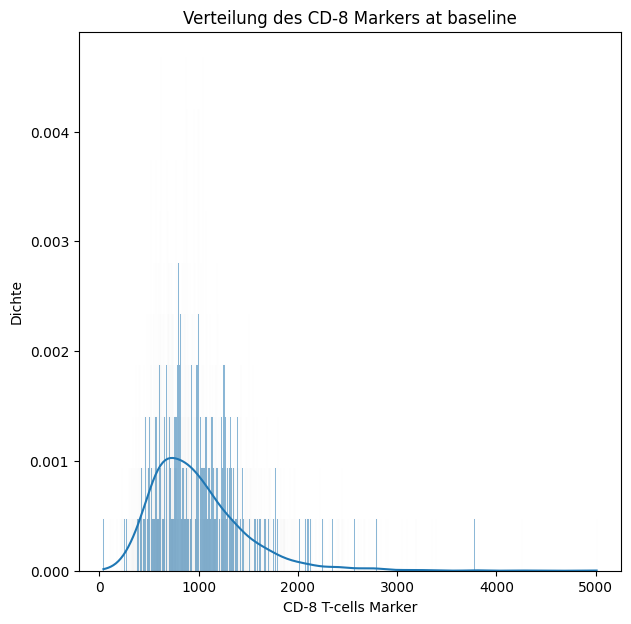

In [33]:
plt.figure(figsize=(7,7))
plot1 = sns.histplot(aids['cd80'], binwidth=1, kde=True, stat="density") #stat["frequency", "density", "probability"]
plot1.set_title("Verteilung des CD-8 Markers at baseline", fontsize=12) # Beschriftungen aus pyplot
plot1.set_ylabel("Dichte", fontsize=10)
plot1.set_xlabel("CD-8 T-cells Marker", fontsize=10)

Text(0.5, 0, 'CD-8 T-cells Marker')

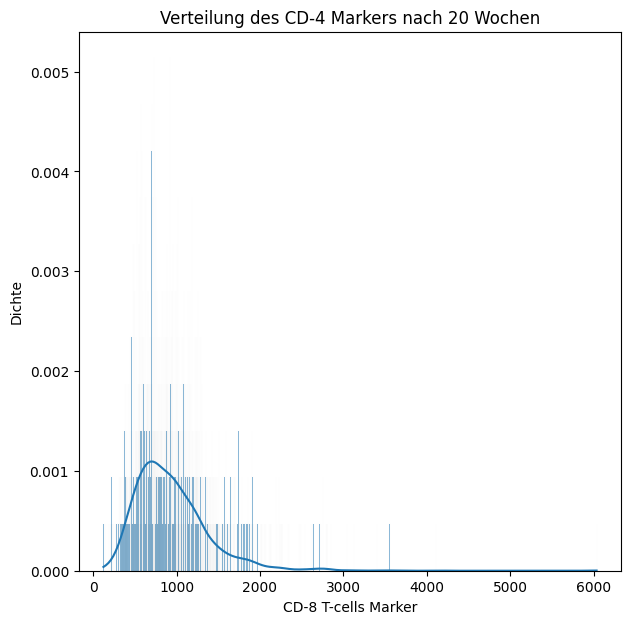

In [34]:
# nach 20 Wochen

plt.figure(figsize=(7,7))
plot1 = sns.histplot(aids['cd820'], binwidth=1, kde=True, stat="density") #stat["frequency", "density", "probability"]
plot1.set_title("Verteilung des CD-4 Markers nach 20 Wochen", fontsize=12) # Beschriftungen aus pyplot
plot1.set_ylabel("Dichte", fontsize=10)
plot1.set_xlabel("CD-8 T-cells Marker", fontsize=10)

### Korrelationsmatrix

<span style=color:red>Nota bene</span>: `karnof` geht an der Stelle als 'integer' in die Korrelation. 

In [35]:
corrma = aidsnum.corr(method='spearman')
corrma.style.background_gradient(cmap='coolwarm')

,time,age,wtkg,karnof,preanti,cd40,cd420,cd80,cd820
time,1.000000,0.044681,0.019738,0.083068,0.087116,0.190958,0.315865,0.022821,0.041613
age,0.044681,1.000000,0.151817,-0.084544,0.127358,-0.040034,-0.049866,0.053787,0.047474
wtkg,0.019738,0.151817,1.000000,0.040878,-0.075844,0.047455,0.031925,0.094099,0.083855
karnof,0.083068,-0.084544,0.040878,1.000000,-0.039288,0.071484,0.094698,-0.003408,0.015441
preanti,0.087116,0.127358,-0.075844,-0.039288,1.000000,-0.110194,-0.203984,0.038068,0.027637
cd40,0.190958,-0.040034,0.047455,0.071484,-0.110194,1.000000,0.620002,0.228328,0.078015
cd420,0.315865,-0.049866,0.031925,0.094698,-0.203984,0.620002,1.000000,0.059500,0.218216
cd80,0.022821,0.053787,0.094099,-0.003408,0.038068,0.228328,0.059500,1.000000,0.741512
cd820,0.041613,0.047474,0.083855,0.015441,0.027637,0.078015,0.218216,0.741512,1.000000


## Visualisierung möglicher Zusammenhänge der Features

### Gewicht und Alter

<Axes: xlabel='age', ylabel='wtkg'>

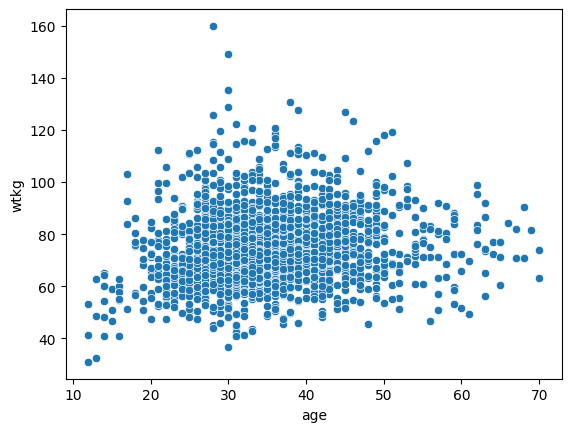

In [36]:
sns.scatterplot(aidsnum, x='age', y='wtkg')

Gut.

### Gewicht und CD-4 at baseline

<Axes: xlabel='wtkg', ylabel='cd40'>

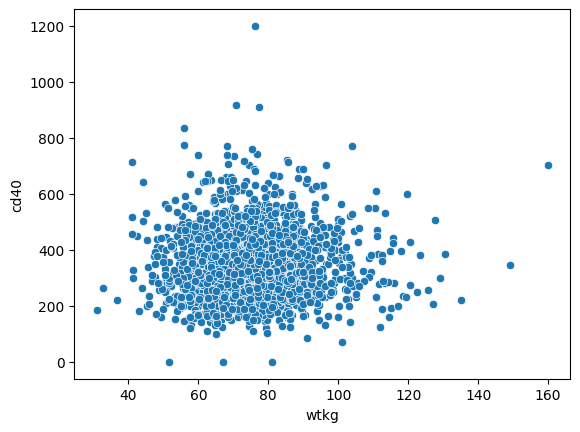

In [37]:
sns.scatterplot(aidsnum, x='wtkg', y='cd40')

### Gewicht und CD-8 at baseline

<Axes: xlabel='wtkg', ylabel='cd80'>

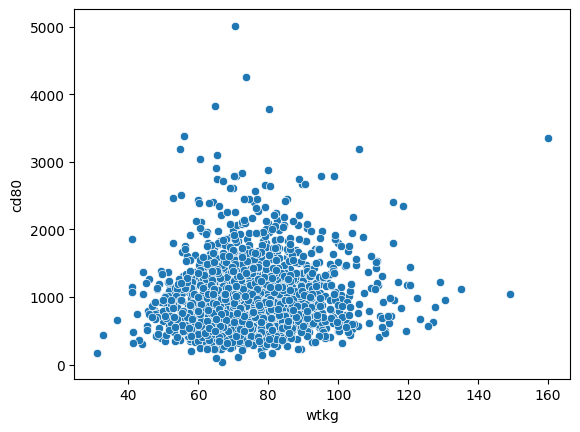

In [38]:
sns.scatterplot(aidsnum, x='wtkg', y='cd80')

### Alter und CD-4 at baseline

<Axes: xlabel='age', ylabel='cd40'>

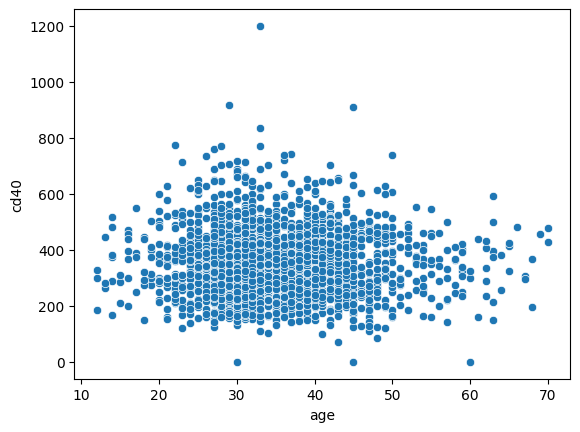

In [39]:
sns.scatterplot(aidsnum, x='age', y='cd40')

### Alter und CD-8 at baseline

<Axes: xlabel='age', ylabel='cd80'>

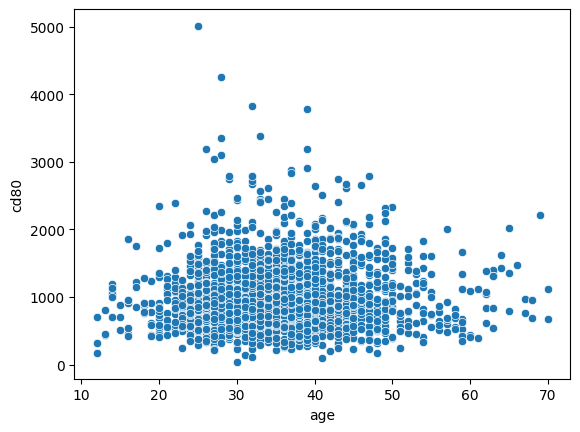

In [40]:
sns.scatterplot(aidsnum, x='age', y='cd80')

Gut.

### Karnofsky-Problem

Karnofsky-Score beschreibt die Operationalisierung des Allgemeinzustands eines Patienten in einer Skala von 0 (Tod) bis 100 (Normalzustand), in der Regel in 10er-Abständen (20-30-40 usw.). Allerdings ist die prozentuale Zuweisung eher als eine beschreibende Richtlinie zu verstehen und nicht als exakte Definierung der einzelnen Prozentpunkte. 

In den vorliegenden Daten liegt der Karnofsky-Score studiendesign-bedingt nur ab 70%.

<Axes: xlabel='age', ylabel='karnof'>

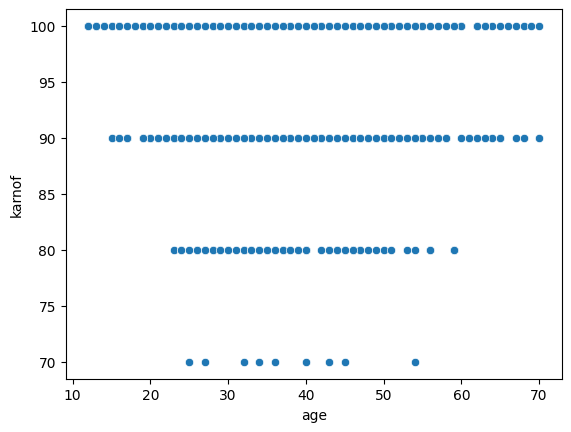

In [41]:
# scatter-plot für Alter und Karnofsky-Index (Score für den allgemeinen Zustand)
sns.scatterplot(aidsnum, x='age', y='karnof')

In [42]:
# der Karnofsky-Score < 70% war ein Ausschlusskriterium.  Daher nur die 4 Levels.
# Theoretisch ist der Score eine Intervalskala von 0 bis 100 mit 10er Abstand.
aidsnum.value_counts(["karnof"])

karnof
100       1263
90         787
80          80
70           9
Name: count, dtype: int64

Der Grund, warum Karnofsky-70% in Boxplots anders abschneidet kann das kleine n=9 sein. Überlegung 70% und 80% zu poolen. <== Update: wurde nach ECOG zusammengefasst. s.u.

In [43]:
dict1

[{0: 'ZDV-only', 1: 'ZDV+ddI', 2: 'ZDV+Zal', 3: 'ddI-only'},
 {0: 'no-hemophilia', 1: 'hemophilia'},
 {0: 'no-homosexual', 1: 'homosexual'},
 {0: 'no-IV-drugs', 1: 'IV-drugs'},
 {0: 'no-prior-ARVT(no-ZDV)', 1: 'prior-ARVT(no-ZDV)'},
 {0: 'no-ZDV-Ther-30d-befor-random', 1: 'ZDV-Ther-30d-befor-random'},
 {0: 'no ZDV-Therapy befor randomisation',
  1: 'ZDV-Therapy befor randomisation'},
 {0: 'White', 1: 'Non-White'},
 {0: 'Female', 1: 'Male'},
 {0: 'naive', 1: 'experienced'},
 {1: 'Antiretroviral-Naive',
  2: '>1-but<= 52-weeks-of-prior-ARVT',
  3: '>52-weeks-of-prior-ARVT'},
 {0: 'asymptomatic', 1: 'symtomatic'},
 {0: 'ZDV only', 1: 'others'},
 {0: 'no off trt befor 96 weeks', 1: 'off trt befor 96 weeks'},
 {0: 'censoring', 1: 'failure'}]

In [44]:
len(stri)

15

### Gewicht und Zeit seit der vorigen antiretroviralen Therapie

<Axes: xlabel='wtkg', ylabel='preanti'>

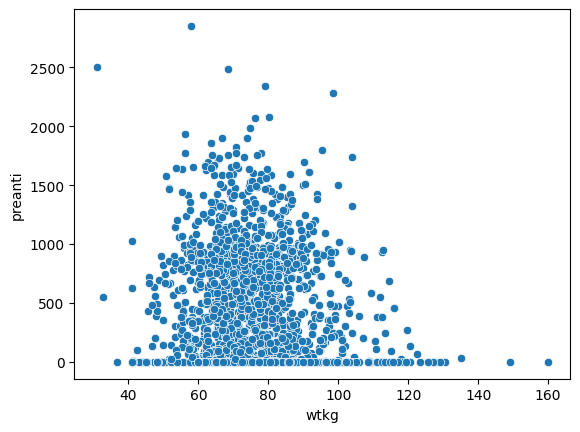

In [45]:
# scatter-plot für Gewicht at baseline und Zeit der vorigen Antiretroviralen Behandlung
sns.scatterplot(aidsnum, x='wtkg', y='preanti')

### CD-8 und die Zeit seit der vorigen antiretroviralen Therapie

<Axes: xlabel='cd80', ylabel='preanti'>

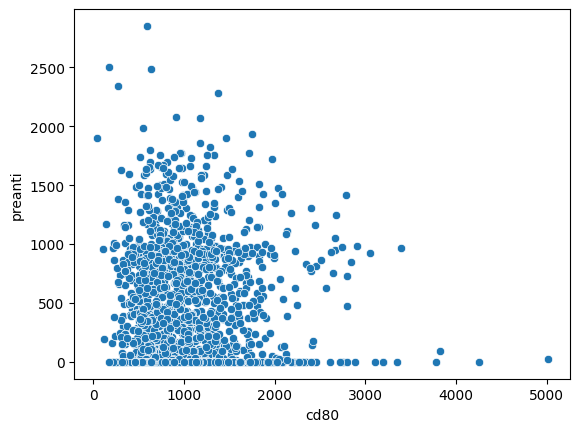

In [46]:
# scatter-plot für CD80 und at baseline und Zeit der vorigen Antiretroviralen Behandlung
sns.scatterplot(aidsnum, x='cd80', y='preanti')

<Axes: xlabel='cd820', ylabel='preanti'>

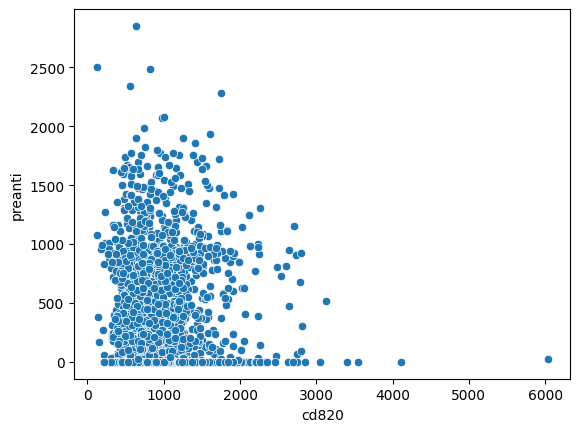

In [47]:
# scatter-plot für CD820 und nach 20 Wochen und Zeit der vorigen Antiretroviralen Behandlung
sns.scatterplot(aidsnum, x='cd820', y='preanti')

 <span style=color:green> Gut. </span> Augenscheinlich besteht **kein** offensichtlicher Zusammenhang zwischen den beiden CD-T-cells mit `preanti` Zeit in Tagen seit einer antiretroviralen Therapie. N.B. auch gleich aus der `Korrelationsmatrix` zu sehen. <span style=color:red> Update: </span> Entschluss den Informationsverlust in Kauf zu nehmen und die `preanti` nicht behalten. Eine detailierte Dauer-Angabe in Tagen wird wohl kaum in den 'unbekannten' neuen Testdaten erhalten sein. Es wird eine kategoriale Variable `strat` die reduzierte Information zur Verfügung stellen.

### CD4 und vorige antiretrovirale Therapie

Text(0.5, 0, 'Vorige antiretrovirale Therapie')

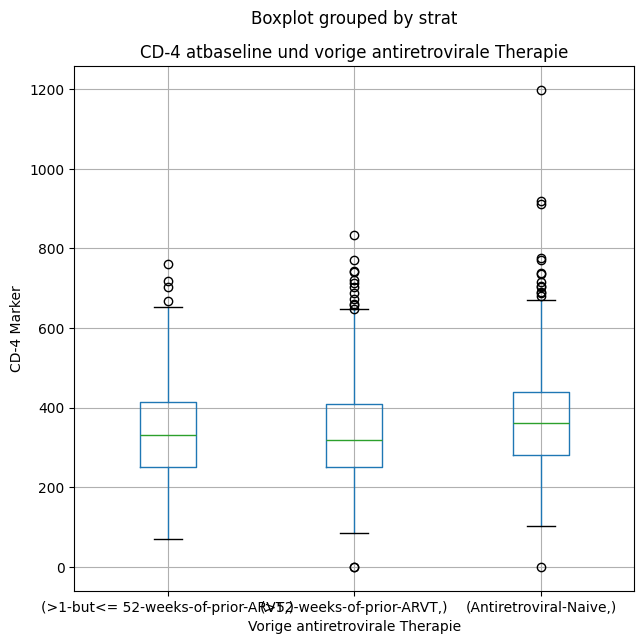

In [48]:
# die Visualisierung der stetigen UND kategorialen Parameter erfolgt ab der Stelle mit dem kompletten 'aids' Datensatz.
plot = aids.boxplot(['cd40'], by=['strat'], figsize=(7,7), return_type='both') #

plt.title("CD-4 atbaseline und vorige antiretrovirale Therapie", fontsize=12)
plt.ylabel("CD-4 Marker", fontsize=10)
plt.xlabel("Vorige antiretrovirale Therapie", fontsize=10)

### CD8 und vorige antiretrovirale Therapie

Text(0.5, 0, 'Vorige antiretrovirale Therapie')

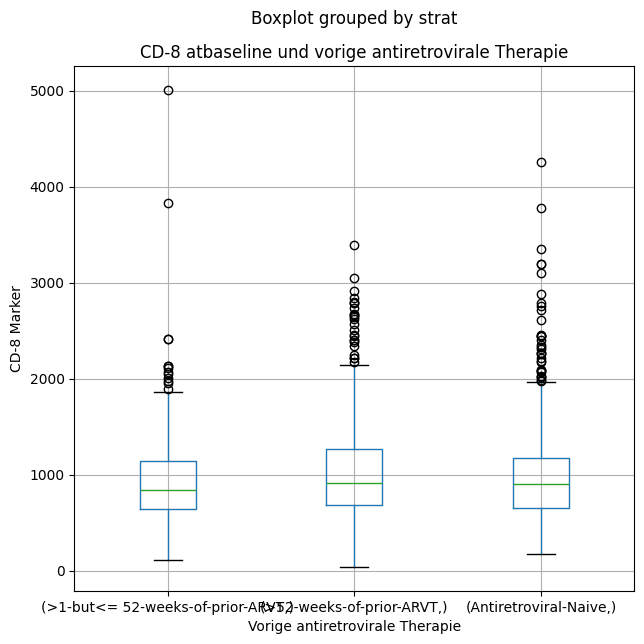

In [49]:
plot = aids.boxplot(['cd80'], by=['strat'], figsize=(7,7), return_type='both') #

plt.title("CD-8 atbaseline und vorige antiretrovirale Therapie", fontsize=12)
plt.ylabel("CD-8 Marker", fontsize=10)
plt.xlabel("Vorige antiretrovirale Therapie", fontsize=10)

Es ist kein Unterschied in der Ausprägung von CD-8 Marker at baseline in den Kategorien der vorigen antiretroviralen Therapie zu beobachten.

### CD4 und CD8 Scatterplots

Hier werden mögliche Abhängigkeiten zwischen den beiden CD Markern at baseline und nach 20 Wochen geprüft.

<Axes: xlabel='cd40', ylabel='cd80'>

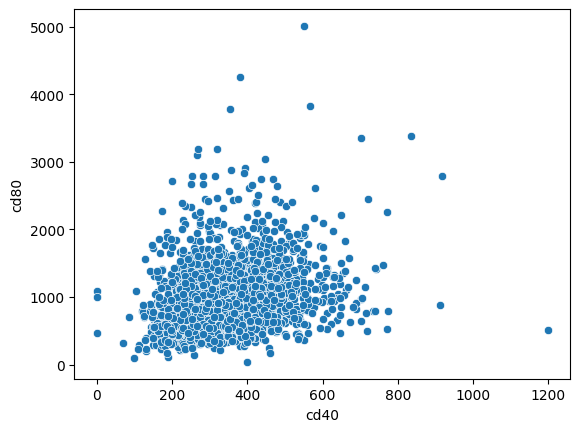

In [50]:
#cd80, cd80 scatter-plot der CD-Proteine at baseline
sns.scatterplot(aidsnum, x='cd40', y='cd80')


<Axes: xlabel='cd40', ylabel='cd420'>

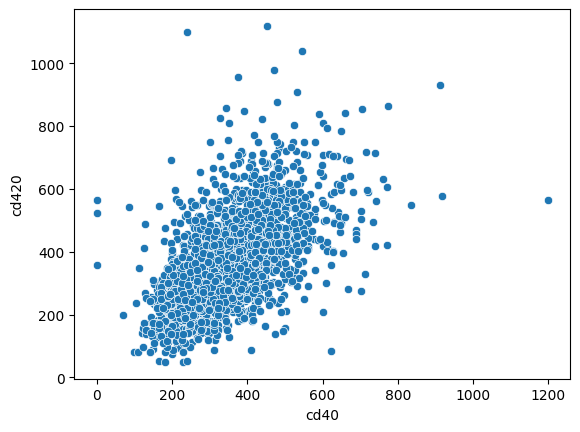

In [51]:
# CD4 at baseline und 20 Wochen später
sns.scatterplot(aidsnum, x='cd40', y='cd420')

<Axes: xlabel='cd80', ylabel='cd820'>

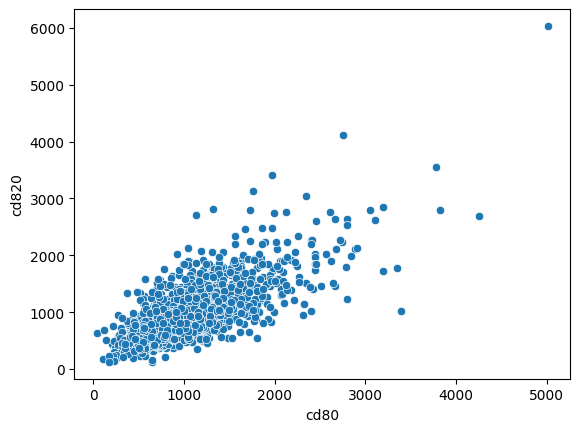

In [52]:
# CD8 at baseline udn 20 Wochen später
sns.scatterplot(aidsnum, x='cd80', y='cd820')

Es lohnt sich den CD-Marker im Verlauf für die Prädiktion zu behalten. Allerdings zeigen beide Marker CD4 und CD8 Anhängigkeiten bei Messpunkten at baseline und 20 Wochen später. Um dies zu umgehen wird je Marker ein neues Feature der Differenz zwischen dem Zeitpunkt *nach 20 Wochen* und *at baseline* erstellt. <span style="color:red"> Eventuell bekomme ich ein **Problem** mit negativen Differenzen. </span> 

Oder es kann ein CD4/CD8-Ratio gebildet werden. <span style=color:green> <== verworfen.</span> 

<span style="color:green">**NOTE:**</span> What is the normal CD4 count for a healthy person?
The CD4 cell count of a person who does not have HIV can be anything between 500 and 1500. People living with HIV who have a CD4 count over 500 are usually in pretty good health. People living with HIV who have a CD4 cell count below 200 are at high risk of developing serious illnesses. [Quelle](https://www.aidsmap.com/about-hiv/cd4-cell-counts)

### CD4 Differenz

In [53]:
aids["cd4-diff"] = (aids["cd420"]-aids["cd40"])

In [54]:
np.min(aids["cd4-diff"])

np.int64(-634)

In [55]:
np.median(aids["cd4-diff"])

np.float64(13.0)

In [56]:
np.max(aids["cd4-diff"])

np.int64(860)

Text(0.5, 0, 'CD4 nach 20 Wochen - CD4 at baseline')

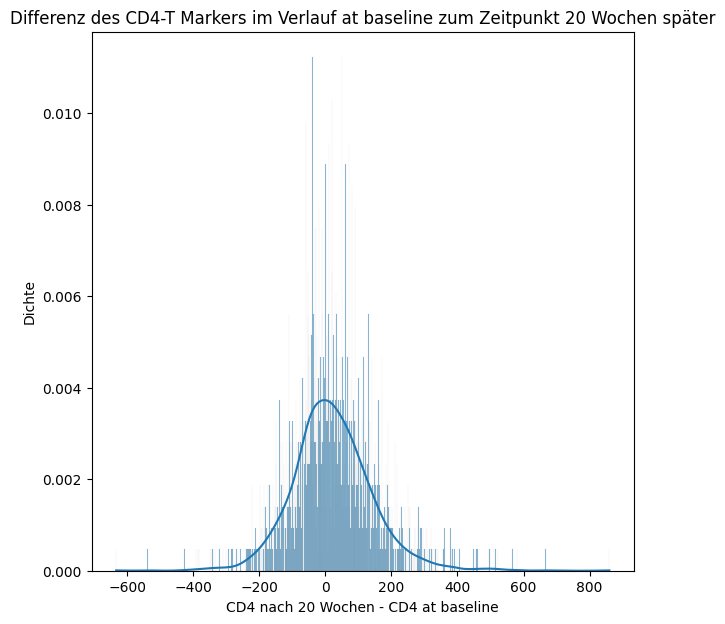

In [57]:
plt.figure(figsize=(7,7))
plot1 = sns.histplot(aids['cd4-diff'], binwidth=1, kde=True, stat="density") #stat["frequency", "density", "probability"]
plot1.set_title("Differenz des CD4-T Markers im Verlauf at baseline zum Zeitpunkt 20 Wochen später", fontsize=12) # Beschriftungen aus pyplot
plot1.set_ylabel("Dichte", fontsize=10)
plot1.set_xlabel("CD4 nach 20 Wochen - CD4 at baseline", fontsize=10)

### CD8 DIfferenz

In [58]:
aids["cd8-diff"] = (aids["cd820"]-aids["cd80"])

Text(0.5, 0, 'CD8 nach 20 Wochen - CD8 at baseline')

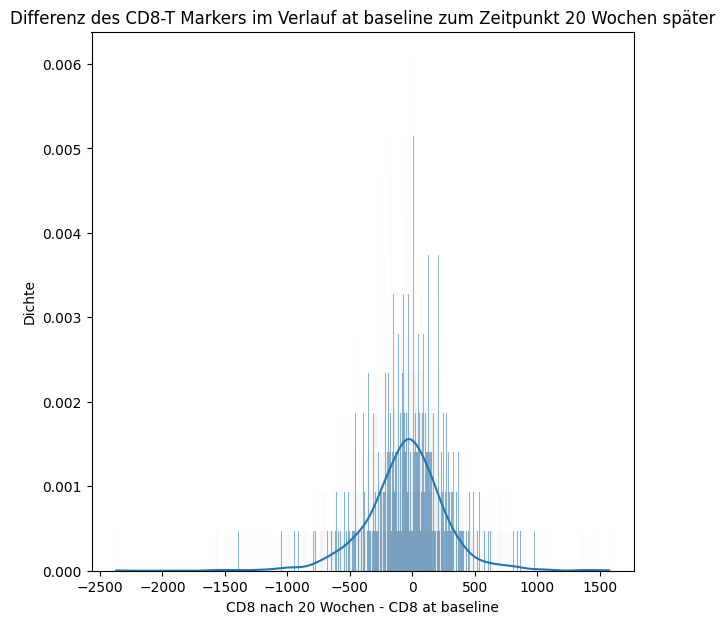

In [59]:
plt.figure(figsize=(7,7))
plot4 = sns.histplot(aids['cd8-diff'], binwidth=1, kde=True, stat="density") #stat["frequency", "density", "probability"]
plot4.set_title("Differenz des CD8-T Markers im Verlauf at baseline zum Zeitpunkt 20 Wochen später", fontsize=12) # Beschriftungen aus pyplot
plot4.set_ylabel("Dichte", fontsize=10)
plot4.set_xlabel("CD8 nach 20 Wochen - CD8 at baseline", fontsize=10)

CD8 scheint stärker auf den Krankheitsverlauf zu reagieren. Die Differenz streut im Vergleich zum CD4 viel breiter und wird eher negativ. 

<span style=color:green> Update:</span> Nach anfänglicher Überlegung für den CD-8 at baseline für Modellbildung zu nehmen, muss aus **inhaltlichen** Gründen doch für den CD-4 at baseline entschieden werden. CD-4 T-Cells ist ein anerkannter Marker in der Immunologie der AIDS-Erkrankung ([Quelle](https://www.aidsmap.com/about-hiv/cd4-cell-counts)). Außerdem weisen die CD-4 T-Cells - im Vergleich zu CD-8 Cells eine geringere Streuung in den Daten. Die Differenz im Verlauf ist - im Gegensatz zu CD-8 - nahezu normalverteilt.

### CD4 : CD8 Ratio

<span style="color:green">**NOTE:**</span> A normal CD4/CD8 ratio is **greater than 1.0**, with CD4 lymphocytes ranging from 500 to 1200/mm 3 and CD8 lymphocytes ranging from 150 to 1000/mm 3. If your ratio is higher than 1, it means your immune system is strong and you may not have HIV. [Quelle](https://www.urmc.rochester.edu/encyclopedia/content?contenttypeid=167&contentid=cd4_cd8_ratio)

In [60]:
aids["cd4-8-ratio"] = (aids["cd40"]/aids["cd80"])

Text(0.5, 0, 'CD4:CD8')

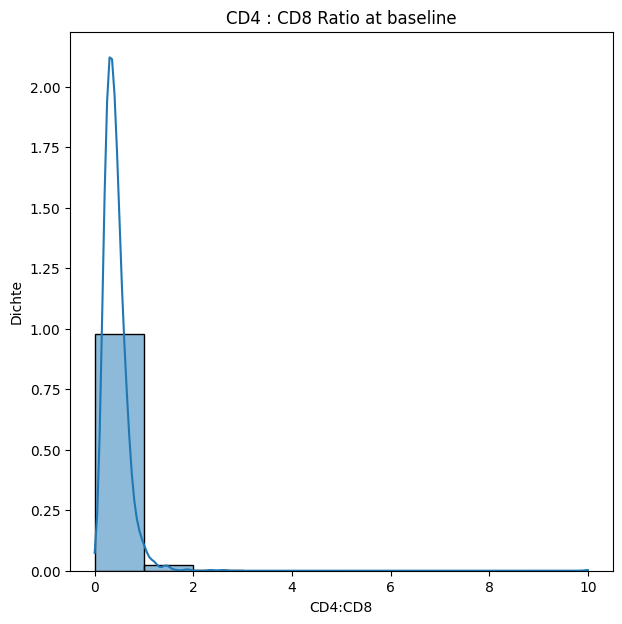

In [61]:
plt.figure(figsize=(7,7))
plot5 = sns.histplot(aids['cd4-8-ratio'], binwidth=1, kde=True, stat="density") #stat["frequency", "density", "probability"]
plot5.set_title("CD4 : CD8 Ratio at baseline", fontsize=12) # Beschriftungen aus pyplot
plot5.set_ylabel("Dichte", fontsize=10)
plot5.set_xlabel("CD4:CD8", fontsize=10)

Das Ratio wird heirmit für weitere Überlegungen verworfen.

### Karnofsky und antiretrovirale Therapie

Text(0.5, 0, 'Karnofsky-Score at baseline in %')

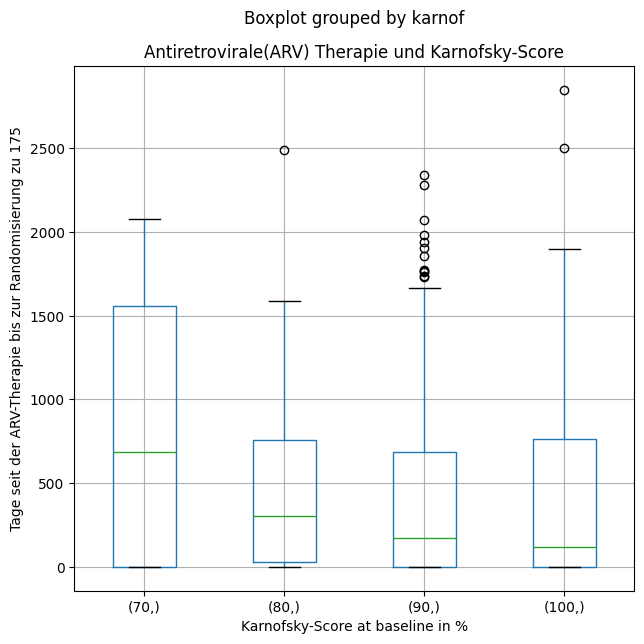

In [62]:
plot6 = aids.boxplot(['preanti'], by=['karnof'], figsize=(7,7), return_type='both') #

plt.title("Antiretrovirale(ARV) Therapie und Karnofsky-Score", fontsize=12)
plt.ylabel("Tage seit der ARV-Therapie bis zur Randomisierung zu 175", fontsize=10)
plt.xlabel("Karnofsky-Score at baseline in %", fontsize=10)

Es ist eine tendenzielle Abhängigkeit zwischen dem Karnofsky-Score und der Dauer der vorigen antiretroviralen Therapie zu sehen. <span style: color="red">WENN</span> Karnofsky-Score als `integer` behandelt wird, spiegelt sich diese Abhägigkeit in einer schwachen negativen Korraltion wieder. D.h. ein eher schwächer Allgemeinzustand geht mit der länger zurückliegenden antiretroviralen Therapie einher. 

<span style=color:green>Update:</span> Die Tage seit der ARVT wurden aufgrund der Redundanz ausgeschlossen.

### Karnofsky und Gewicht

Text(0.5, 0, 'Karnofsky-Score at baseline in %')

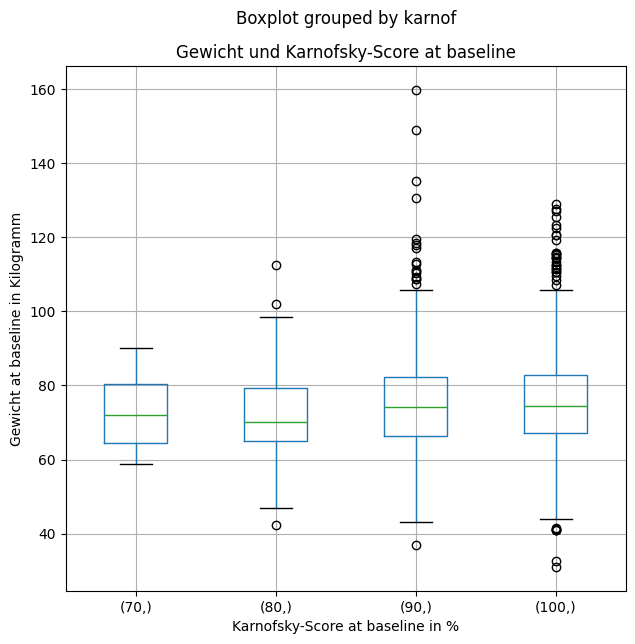

In [63]:
plot7 = aids.boxplot(['wtkg'], by=['karnof'], figsize=(7,7), return_type='both') #

plt.title("Gewicht und Karnofsky-Score at baseline", fontsize=12)
plt.ylabel("Gewicht at baseline in Kilogramm", fontsize=10)
plt.xlabel("Karnofsky-Score at baseline in %", fontsize=10)

Gewicht und Karnofsky dürfen zusammen in die Modellbildung.

### Karnofski und Zeit bis zum Outcome

Text(0.5, 0, 'Karnofsky-Score at baseline in %')

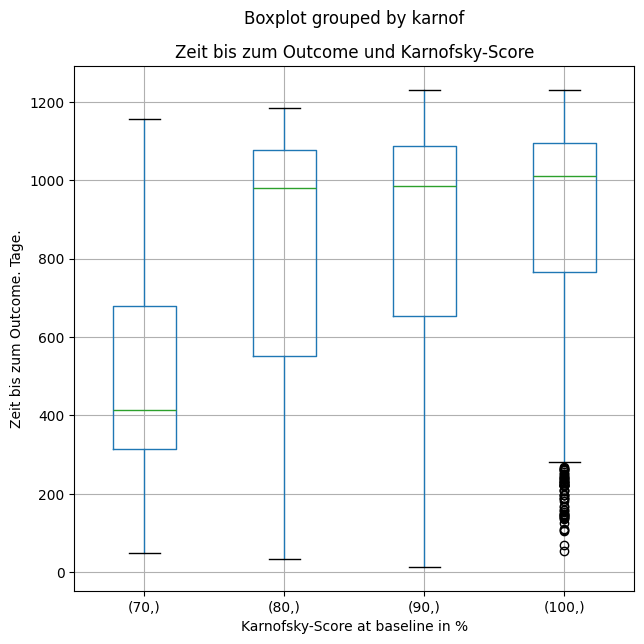

In [64]:
plot8 = aids.boxplot(['time'], by=['karnof'], figsize=(7,7), return_type='both') #

plt.title("Zeit bis zum Outcome und Karnofsky-Score", fontsize=12)
plt.ylabel("Zeit bis zum Outcome. Tage.", fontsize=10)
plt.xlabel("Karnofsky-Score at baseline in %", fontsize=10)

Es scheint, dass nur Karvofsky <= 70% Einfluss auf die Zeit bis zum Outcome hat. Zu beachten gibt es, dass Karnofsky=70% n=9 hat. Eine sehr kleine Subgruppe. 

Außerdem muss überlegt werden, wie wichtig die *Zeit bis zum Outcome* für die Vorhersage ist. Wenn man annimmt, dass die Testdaten (noch) keinen zeitlichen Verlauf haben und man die Vorhersage **at baseline** haben möchte, dann <span style=color:green> kann man die *Zeit bis Outcome* `time` aus den zu modelierenden Daten ausschliessen.</span> Hätte man in den unbekannten Testdaten die *Zeit bis zum Outcome*, bräuchte man die in dieser Arbeit anstrebende Vorhersage nicht.

<span style=color:red> Es bleibt das Problem der kleinen n-Zahl bei Karnofsky=70% </span>



### Karnofsky und CD-4 atbaseline

Text(0.5, 0, 'Karnofsky-Score at baseline in %')

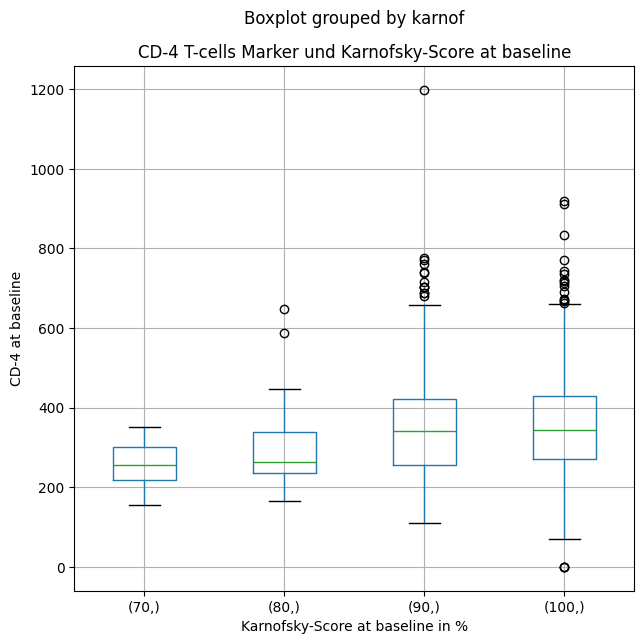

In [65]:
plot = aids.boxplot(['cd40'], by=['karnof'], figsize=(7,7), return_type='both') #

plt.title("CD-4 T-cells Marker und Karnofsky-Score at baseline", fontsize=12)
plt.ylabel("CD-4 at baseline", fontsize=10)
plt.xlabel("Karnofsky-Score at baseline in %", fontsize=10)

Hier ist eine gewisse Tendenz zum besseren CD-4 in Abhängigkeit von Allgemeinzustand (Karnofsky-Score) zu beobachten. Ob der Unterschied signifikant ist, könnte evtl. geprüft werden. Kruskal-Wallis H-test wäre dafür geeignet.

Die Spearman-Korrelationsmatrix zeigt jedoch keinen ausgeprägten r-Wert.

### Karnofsky und CD-8 at baseline

Text(0.5, 0, 'Karnofsky-Score at baseline in %')

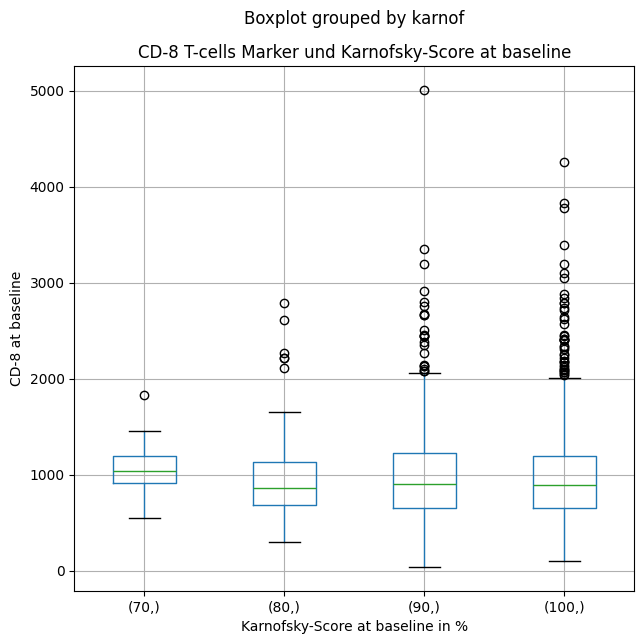

In [66]:
plot9 = aids.boxplot(['cd80'], by=['karnof'], figsize=(7,7), return_type='both') #

plt.title("CD-8 T-cells Marker und Karnofsky-Score at baseline", fontsize=12)
plt.ylabel("CD-8 at baseline", fontsize=10)
plt.xlabel("Karnofsky-Score at baseline in %", fontsize=10)

Gut. Karnofsky und CD-8 at baseline dürfen zusammen in die Modellbildung.

### Karnofsky und CD-8 **Differenz**

Text(0.5, 0, 'Karnofsky-Score at baseline in %')

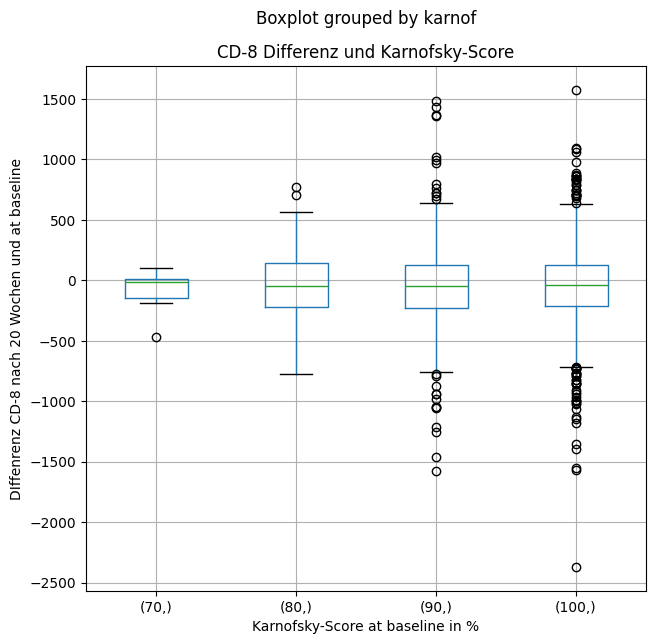

In [67]:
plot10 = aids.boxplot(['cd8-diff'], by=['karnof'], figsize=(7,7), return_type='both') #

plt.title("CD-8 Differenz und Karnofsky-Score", fontsize=12)
plt.ylabel("DIffenrenz CD-8 nach 20 Wochen und at baseline", fontsize=10)
plt.xlabel("Karnofsky-Score at baseline in %", fontsize=10)

Das sieht gut aus. Beide Attribute können in ein Modell mit rein. <span style=color:green>Überlegung:</span> nicht die Differenz, sondern den CD-8 Marker at baseline in die Modellvergleiche aufnehmen. Die Grafik zeigt, dass CD-8 auch im Zeitverlauf ein unabhängiger Marker in Bezug auf Allgemeinzustand (Karnofsky-Score) ist.

<span style=color:green>Update:</span> Es wurde CD-4 at baseline aus inhaltlichen Gründen (etablierter immunogener Marker) genommen. 

### ZDV Treatment und Zeit bis zum outcome

Text(0.5, 0, 'ZDV Treatment')

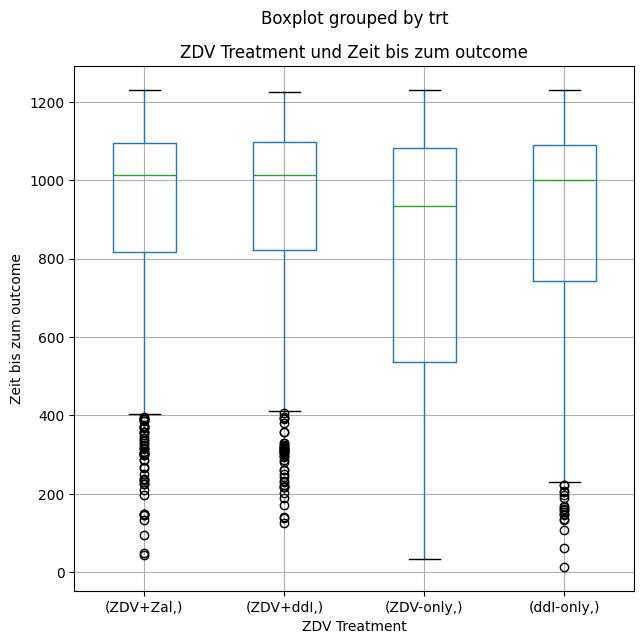

In [68]:
plot11 = aids.boxplot(['time'], by=['trt'], figsize=(7,7), return_type='both') #

plt.title("ZDV Treatment und Zeit bis zum outcome", fontsize=12)
plt.ylabel("Zeit bis zum outcome", fontsize=10)
plt.xlabel("ZDV Treatment", fontsize=10)

<span style=color:red> Hm, </span> ok, keine voreilige Interprätationen anstellen. Die `time` ist eh aus inhaltlichen Gründen raus. Aber als Treatment kann auch - trotz des noch nicht berücksichtigten aber z.Z. vernachlessigbaren Informationsverlustes - das binäre `treat` (ZDV only vs. others) genommen werden. <span style=color:green> Update:</span> Entschluss das Treatment mit 4 Kategorien belassen, weil die Subgruppen randomisiert und von der Größe her gleich sind. Außerdem werden keine comparativen Analysen bezüglich Treatment und Target durchgeführt ==> kein Argument für das Poolen von Kategorien wird errechnet.

### Race und Zeit bis zum outcome

Text(0.5, 0, 'Rasse')

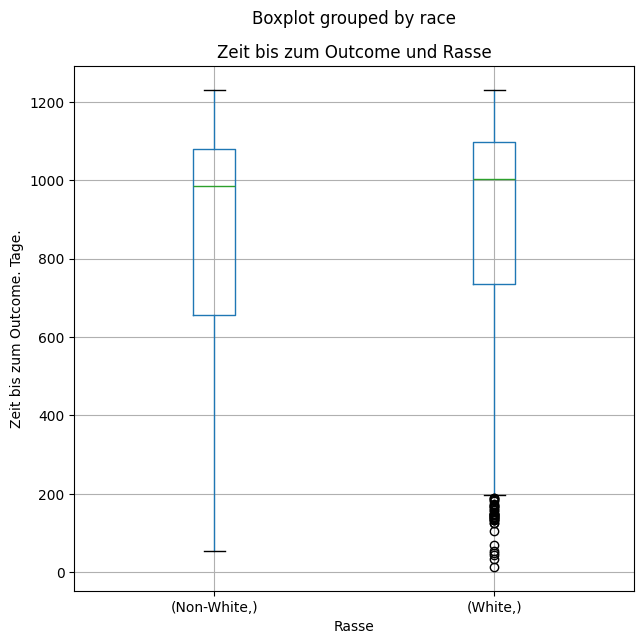

In [69]:
plot12 = aids.boxplot(['time'], by=['race'], figsize=(7,7), return_type='both') #

plt.title("Zeit bis zum Outcome und Rasse", fontsize=12)
plt.ylabel("Zeit bis zum Outcome. Tage.", fontsize=10)
plt.xlabel("Rasse", fontsize=10)


### Race und Gewicht

Text(0.5, 0, 'Rasse')

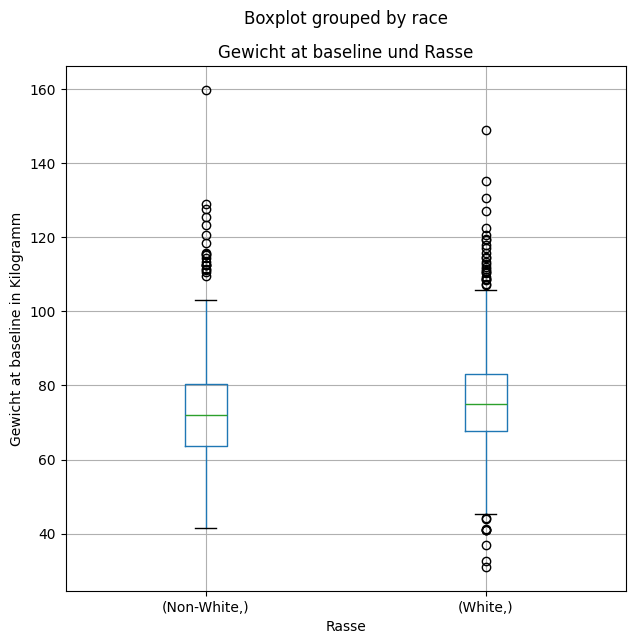

In [70]:
plot13 = aids.boxplot(['wtkg'], by=['race'], figsize=(7,7), return_type='both') #

plt.title("Gewicht at baseline und Rasse", fontsize=12)
plt.ylabel("Gewicht at baseline in Kilogramm", fontsize=10)
plt.xlabel("Rasse", fontsize=10)

`Gewicht`und `Race` dürfen zusammen in die Modellbildung.

### Sexualität und Gewicht

Text(0.5, 0, 'Sexualität')

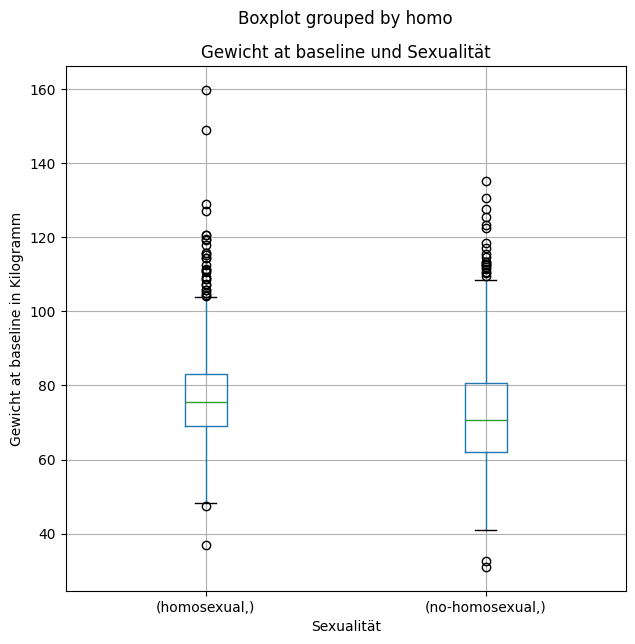

In [71]:
plot14 = aids.boxplot(['wtkg'], by=['homo'], figsize=(7,7), return_type='both') #

plt.title("Gewicht at baseline und Sexualität", fontsize=12)
plt.ylabel("Gewicht at baseline in Kilogramm", fontsize=10)
plt.xlabel("Sexualität", fontsize=10)

<span style=color:red> HM, etwas Bedenken bzgl. des kleinen Unterschieds. </span> Da die Gruppen unterschiedlich groß sind, könnte noch der Drogenkonsum bei nicht Homosexuellen eine Rolle spielen, warum sie in den Daten sind. Wenn die Confusion-Matrix `Sexualität`und `Drogenkonsum` Auffälligkeiten ergibt, wird eine Überlegung erfolgen sollen, ob und wie man mit den drei Attributen verfährt. 

Zumidest für den **Random Forest** wird diese Abhängigkeit nicht vom Gewicht sein. Für **SVM** wegen der optimalen Kernel auch nicht. <span style=color:red> Augen auf bei *LogReg*. </span>

<span style=color:green>Update:</span> Gewicht ist raus.

### Gewicht und Drogenkonsum

Text(0.5, 0, 'Drogenkonsum')

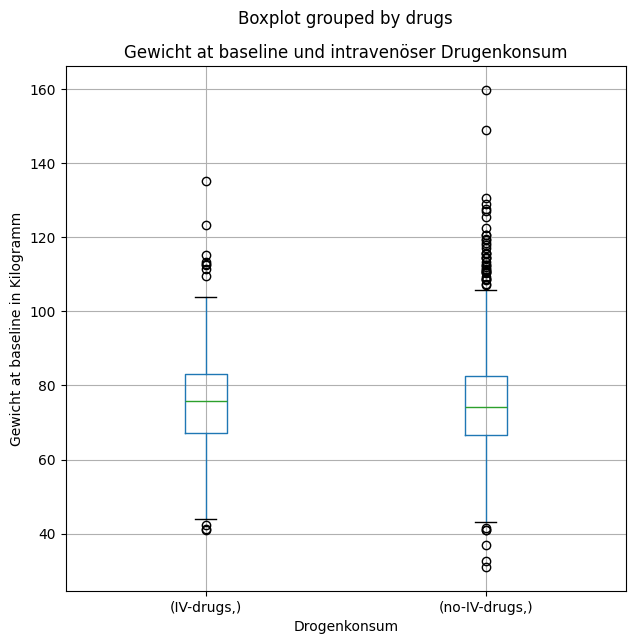

In [72]:
plot15 = aids.boxplot(['wtkg'], by=['drugs'], figsize=(7,7), return_type='both') #

plt.title("Gewicht at baseline und intravenöser Drugenkonsum", fontsize=12)
plt.ylabel("Gewicht at baseline in Kilogramm", fontsize=10)
plt.xlabel("Drogenkonsum", fontsize=10)

Gut. Gewicht und Drogenkonsum dürfen zusammen in die Modellbildung.

## Confusion Matrix

In diesem Teil werden die kategorialen Features auf die möglichen Abhängigkeiten untereinander gepfüft.

In [73]:
var1 = aids["hemo"].replace(hemo_dict)
var2 = aids["homo"].replace(homo_dict)
v1 = pd.Series(var1,name="Hemophilia")
v2 = pd.Series(var2, name="Homosexuality")
df_confusion = pd.crosstab(v1, v2, margins=False) 
# wenn margins=True ist, werden noch die Zeilensummen ausgegeben = keine 2x2 Tabelle mehr.
df_confusion

Homosexuality,homosexual,no-homosexual
Hemophilia,,
hemophilia,9,171
no-hemophilia,1405,554


### Sexualität und Drogen

In [74]:
var1 = aids["drugs"]
var2 = aids["homo"]
v1 = pd.Series(var1,name="Drugs")
v2 = pd.Series(var2, name="Homosexuality")
df_confusion2 = pd.crosstab(v1, v2, margins=False) 
# wenn margins=True ist, werden noch die Zeilensummen ausgegeben = keine 2x2 Tabelle mehr.
df_confusion2

Homosexuality,homosexual,no-homosexual
Drugs,,
IV-drugs,115,166
no-IV-drugs,1299,559


Ok, 11,3 für `homo` zu 3,3 für `no homo` Rate bzgl. des Drogenkonsums: anscheinend werden die Drogenabhängigen eher an HIV erkranken. Die evtl Probs mit LogReg im Hinterkopf behalten.

### Sexualität und Race

In [75]:
var1 = aids["race"]
var2 = aids["homo"]
v1 = pd.Series(var1,name="Race")
v2 = pd.Series(var2, name="Homosexuality")
df_confusion3 = pd.crosstab(v1, v2, margins=False) 
# wenn margins=True ist, werden noch die Zeilensummen ausgegeben = keine 2x2 Tabelle mehr.
df_confusion3

Homosexuality,homosexual,no-homosexual
Race,,
Non-White,267,350
White,1147,375


### Intravenöse Drogen und Race

In [76]:
var1 = aids["drugs"]
var2 = aids["race"]
v1 = pd.Series(var1,name="i.v. Drugs")
v2 = pd.Series(var2, name="Race")
df_confusion4 = pd.crosstab(v1, v2, margins=False) 
# wenn margins=True ist, werden noch die Zeilensummen ausgegeben = keine 2x2 Tabelle mehr.
df_confusion4

Race,Non-White,White
i.v. Drugs,,
IV-drugs,108,173
no-IV-drugs,509,1349


### Karnofsky und vorige ZDV-Therapie

In [77]:
var1 = aids["z30"].replace(z30_dict)
var2 = aids["karnof"]
v1 = pd.Series(var1,name="vorige ZDV-Therapie")
v2 = pd.Series(var2, name="Karnofsky-Score")
df_confusion4 = pd.crosstab(v1, v2, margins=False) 

df_confusion4

Karnofsky-Score,70,80,90,100
vorige ZDV-Therapie,,,,
ZDV-Ther-30d-befor-random,6,59,447,665
no-ZDV-Ther-30d-befor-random,3,21,340,598


Annährend OK.

### Karnofsky und Symptome

In [78]:
var1 = aids["symptom"].replace(symptom_dict)
var2 = aids["karnof"]
v1 = pd.Series(var1,name="akute Symptome")
v2 = pd.Series(var2, name="Karnofsky-Score")
df_confusion5 = pd.crosstab(v1, v2, margins=False) 

df_confusion5

Karnofsky-Score,70,80,90,100
akute Symptome,,,,
asymptomatic,6,56,624,1083
symtomatic,3,24,163,180


## Der finale Datensatz für die Modellbildung


Da es für die Modellierung numerische "Labels" braucht, wird <span style=color:red> nach Visualisierung im Preprocessing</span> mit dem gelabelten `aids` Datensatz wieder mit dem ungelabelten Datensatz gearbeitet.

In [79]:
#import os
#os.getcwd()
#os.chdir(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))


aids0 = pd.read_csv('data/aids.csv', sep =",")

In [80]:
aids0.columns

Index(['num', 'time', 'trt', 'age', 'wtkg', 'hemo', 'homo', 'drugs', 'karnof',
       'oprior', 'z30', 'zprior', 'preanti', 'race', 'gender', 'str2', 'strat',
       'symptom', 'treat', 'offtrt', 'cd40', 'cd420', 'cd80', 'cd820', 'cid'],
      dtype='object')

### Datenreduktion: Prädiktiver Mehrwert

<span style=color: green> Das Ziel der Prädiktion: </span> Die Vorhersage des Überlebens mit einer HIV-Infektion unter ZDV-Therapie anhand von einer Reihe klinischer, demografischer und sozio-kultureller Parameter. Diese Parameter sollen 1. einen prädiktiven Mehrwert für das Target haben und 2. in den unbekannten neuen Daten leicht verfügbar sein. 
Daher wurde der Beschluss gefasst:

1. nur die Daten in die Modellierung aufzunehmen, die zum Zeitpunkt der Randomisierung vorlagen: at baseline, 
2. die redundanten Parameter auszuschliessen (bsplw. die Dauer seit der letzten antiretroviralen Therapie in Tagen, binarisiertes Treatment),
3. nur die Parameter mit einem prädiktiven Mehrwert (inhaltlich begründet) zu behalten (bsplw. ist Gewicht ohne Größe nicht aussagekräftig) und
4. die Parameter, die keinen sichtbaren Zusammenhang (über Visualisierung bzw. Korrelationsmatrix) aufweisen.

Durch Gruppenbildung soll weitere Paramterreduktion erfolgen. Für das Zusammenfassen des Karnofsky-Scores bietet sich die von Eastern Cooperative Oncology Group [ECOG](https://ecog-acrin.org/resources/ecog-performance-status/) vorgeschlagene Gradierung an. So würden auf Datengrundlage zwei Gruppen, *normal* (Karnofsky 90-100%) und *ambulant* (Karnofsky 70-80%) entstehen. Die Daten beinhalten aufgrund des [Studiendesigns](https://www.nejm.org/doi/full/10.1056/NEJM199610103351501) nur Karnofsky >= 70%. Diese Informationsreduktion ermöglicht das bessere Handing von Karnofsky-Information und hat Vorteil bei One-Hot-Encoding.

Es bleiben:

|Num|df-num|Name|Rolle|Beschreibung|
|---|------|----|-----|------------|
1|1  | cid      |  Target    |   censoring indicator (1 = failure, 0 = censoring)  
2|3  | trt      |  Feature   |  treatment indicator (0 = ZDV only; 1 = ZDV + d...  
3|4  | age      |  Feature   |  age (yrs) at baseline  
4|6  | hemo     |  Feature   |  hemophilia (0=no, 1=yes)  
5|7  | homo     |  Feature   |  homosexual activity (0=no, 1=yes)  
6|8  | drugs    |  Feature   |  history of IV drug use (0=no, 1=yes)  
7|9  | ecog   |  Feature   |  Karnofsky score nach ECOG (0=90-100%, 1=70-80%)
8|11 | z30      |  Feature   |  ZDV in the 30 days prior to 175 (0=no, 1=yes)  
9|14 | race     |  Feature   |  race (0=White, 1=non-white)  
10|15 | gender   |  Feature   |  gender (0=F, 1=M)  
11|17 | strat    |  Feature   |  antiretroviral history stratification (1='Anti...  
12|18 | symptom  |  Feature   |  symptomatic indicator (0=asymp, 1=symp)  
13|21 | cd40     |  Feature   |   CD4 at baseline  

In [81]:
#Gruppiren des Karnofsky-Scores
def func(x):
    if 90 <= x <= 100:
        return 0
    elif  70 <= x <= 80:
        return 1

aids0["ecog"] = aids0["karnof"].apply(func)

#ecog_dict = {0: "90-100%", 1: "70-80%"}
#dict1.append(ecog_dict)

aids0.ecog.value_counts()

ecog
0    2050
1      89
Name: count, dtype: int64

In [82]:
to_drop = ["num","time", "wtkg", "karnof", "oprior", "zprior","preanti","str2","treat","offtrt","cd80","cd420","cd820"] #, 'cd4-diff', 'cd8-diff', 'cd4-8-ratio'
aids0 = aids0.drop(to_drop, axis=1)

In [83]:
# ungelabelten datensatz speichern
aids0 = aids0.to_csv('data/aids0.csv')

In [84]:
aids["ecog"] = aids["karnof"].apply(func)

#ecog_dict = {0: "90-100%", 1: "70-80%"}
#dict1.append(ecog_dict)

aids.ecog.value_counts()

ecog
0    2050
1      89
Name: count, dtype: int64

In [85]:
to_drop = ["num","time", "wtkg", "karnof", "oprior", "zprior","preanti","str2","treat","offtrt","cd80","cd420","cd820", 'cd4-diff', 'cd8-diff', 'cd4-8-ratio'] #
aidsfin = aids.drop(to_drop, axis=1)

In [86]:
aidsfin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2139 entries, 0 to 2138
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   trt      2139 non-null   object
 1   age      2139 non-null   int64 
 2   hemo     2139 non-null   object
 3   homo     2139 non-null   object
 4   drugs    2139 non-null   object
 5   z30      2139 non-null   object
 6   race     2139 non-null   object
 7   gender   2139 non-null   object
 8   strat    2139 non-null   object
 9   symptom  2139 non-null   object
 10  cd40     2139 non-null   int64 
 11  cid      2139 non-null   object
 12  ecog     2139 non-null   int64 
dtypes: int64(3), object(10)
memory usage: 217.4+ KB


In [87]:
# unencodeten datensatz speichern
aidsfin = aidsfin.to_csv('data/aidsfin.csv')
#df wieder holen
aidsfin = pd.read_csv('data/aidsfin.csv', sep =",")


## Transformierung der Parameter
Für `Alter` und `CD-8`. 

Es soll entschieden werden ob Standardisierung mir dem `StandardScaler` oder  die Normalisierung mit dem `MinMacScaler` erfolgen soll. Zu diesem Zweck wird die Verteilung der zu transformierenden Parameter angeschaut (siehe Kapitel "Verteilung der stetigen Parameter").

<span style=color:green>**NOTE:**</span> Die Standardisierung bzw. Normalisierung soll NACH dem *split* VOR der Modellbildung erfolgen.

### Scaler: Überlegungen zur Transformation

Die stetigen Parameter in den realen Daten sind annährend normalverteilt. 
Das würde in Teilen für einen `StandardScaler` sprechen. Allerdings ist es ungewiss, wie die unbekannten 'neuen' Testdaten aussehen würden. Daher fällt die <span style=color:red> Entscheidung</span> auf den `MinMaxScaler`.

### One-Hot Encoding

Damit kein Verhältnis zwischen den numerischen Labels missinterpretiert wird, müssen die kategorialen Parameter gleichgewichtet umgelegt werden.

In [88]:

cat_columns=['trt', 'hemo', 'homo', 'drugs', 'z30', 'race', 'gender', 'strat', 'symptom', 'ecog']

In [89]:
aidsenc = pd.get_dummies(aidsfin, dtype=int, columns=cat_columns, drop_first=True)

In [90]:
aidsenc.head(7)

,Unnamed: 0,age,cd40,cid,trt_ZDV+ddI,trt_ZDV-only,trt_ddI-only,hemo_no-hemophilia,homo_no-homosexual,drugs_no-IV-drugs,z30_no-ZDV-Ther-30d-befor-random,race_White,gender_Male,strat_>52-weeks-of-prior-ARVT,strat_Antiretroviral-Naive,symptom_symtomatic,ecog_1
0,0,48,422,censoring,0,0,0,1,1,1,1,1,0,0,1,0,0
1,1,61,162,failure,0,0,1,1,1,1,0,1,0,1,0,0,0
2,2,45,326,censoring,0,0,1,1,0,0,0,1,1,1,0,0,0
3,3,47,287,censoring,0,0,1,1,0,1,0,1,1,1,0,0,0
4,4,43,504,censoring,0,1,0,1,0,1,0,1,1,1,0,0,0
5,5,46,235,censoring,1,0,0,1,0,0,0,1,1,1,0,0,0
6,6,31,244,failure,0,1,0,1,0,1,0,1,1,1,0,0,0


In [91]:
aidsenc["cid"] = aidsenc["cid"].replace({'failure': 1, 'censoring': 0})

In [92]:
aidsenc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2139 entries, 0 to 2138
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype
---  ------                            --------------  -----
 0   Unnamed: 0                        2139 non-null   int64
 1   age                               2139 non-null   int64
 2   cd40                              2139 non-null   int64
 3   cid                               2139 non-null   int64
 4   trt_ZDV+ddI                       2139 non-null   int64
 5   trt_ZDV-only                      2139 non-null   int64
 6   trt_ddI-only                      2139 non-null   int64
 7   hemo_no-hemophilia                2139 non-null   int64
 8   homo_no-homosexual                2139 non-null   int64
 9   drugs_no-IV-drugs                 2139 non-null   int64
 10  z30_no-ZDV-Ther-30d-befor-random  2139 non-null   int64
 11  race_White                        2139 non-null   int64
 12  gender_Male                       

In [93]:
# für weitere Tables 'Unnamed' Nummerierung enfernen
aidsenc = aidsenc.drop(["Unnamed: 0"],axis=1)

In [94]:
# speichern für die Modellierung
aidsenc = aidsenc.to_csv('data/aidsenc.csv')
